# Objective:
The classification goal is to predict if the client will subscribe
(yes/no) a term deposit (variable y).


# 1. Import the necessary libraries

In [568]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from catboost import CatBoostClassifier
from sklearn import metrics
import seaborn as sns
%matplotlib inline

# 2. Read the data as a data frame

In [569]:
d=pd.read_csv('bank-full.csv')

In [570]:
d.head(10)

age           job   marital  education default  balance housing loan  \
0   58    management   married   tertiary      no     2143     yes   no   
1   44    technician    single  secondary      no       29     yes   no   
2   33  entrepreneur   married  secondary      no        2     yes  yes   
3   47   blue-collar   married    unknown      no     1506     yes   no   
4   33       unknown    single    unknown      no        1      no   no   
5   35    management   married   tertiary      no      231     yes   no   
6   28    management    single   tertiary      no      447     yes  yes   
7   42  entrepreneur  divorced   tertiary     yes        2     yes   no   
8   58       retired   married    primary      no      121     yes   no   
9   43    technician    single  secondary      no      593     yes   no   

   contact  day month  duration  campaign  pdays  previous poutcome Target  
0  unknown    5   may       261         1     -1         0  unknown     no  
1  unknown    5   may       151         1     -1         0  unknown     no  
2  unknown    5   may        76         1     -1         0  unknown     no  
3  unknown    5   may        92         1     -1         0  unknown     no  
4  unknown    5   may       198         1     -1         0  unknown     no  
5  unknown    5   may       139         1     -1         0  unknown     no  
6  unknown    5   may       217         1     -1         0  unknown     no  
7  unknown    5   may       380         1     -1         0  unknown     no  
8  unknown    5   may        50         1     -1         0  unknown     no  
9  unknown    5   may        55         1     -1         0  unknown     no

# 3a. Shape of the data

In [571]:
print("The data has {} entries with {} features".format(d.shape[0],d.shape[1]-1))

The data has 45211 entries with 16 features


# 3b. Data type of each attribute

In [572]:
print(d.dtypes)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object


In [573]:
Category=['job','marital','education','default','housing','loan','contact','month','poutcome']
Numerical=['age','balance','day','duration','campaign','pdays','previous']

# 3C. Checking the presence of missing values


In [574]:
print("The total missing value in the data set=",sum(d.isnull().sum()))

The total missing value in the data set= 0


In [575]:
for feature in d.columns:
    if d[feature].dtype=='object':
        print(feature,d[feature].unique())

job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ['married' 'single' 'divorced']
education ['tertiary' 'secondary' 'unknown' 'primary']
default ['no' 'yes']
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome ['unknown' 'failure' 'other' 'success']
Target ['no' 'yes']


Seems line no '?' or any unwanted data in the dataset

Lets replace the Categorical columns values with suitable numbers to have better data analysis

In [576]:
d1=d.copy()
d1=d1.replace({"Target":{"no":0,"yes":1}})
replaceStruct = {
                "education":{"primary": 1, "secondary": 2 ,"tertiary": 3 ,"unknown":-1},
                "default": {"no": 1, "yes":2},
                "housing": {"no": 1, "yes":2},
                "loan": {"no": 1, "yes":2},
                "month": {"jan": 1, "feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12},     
                "phone": {"no": 1, "yes": 2 },
                "poutcome":{'unknown':-1,'failure':0,'other':0.5,'success':1},
                "marital":{'married':2,'single':1,'divorced':1}}
d1=d1.replace(replaceStruct)

# 3d. 5 point summary of numerical attributes

In [577]:
d1.describe()

age       marital     education       default        balance  \
count  45211.000000  45211.000000  45211.000000  45211.000000   45211.000000   
mean      40.936210      1.601933      2.019442      1.018027    1362.272058   
std       10.618762      0.489505      0.902795      0.133049    3044.765829   
min       18.000000      1.000000     -1.000000      1.000000   -8019.000000   
25%       33.000000      1.000000      2.000000      1.000000      72.000000   
50%       39.000000      2.000000      2.000000      1.000000     448.000000   
75%       48.000000      2.000000      3.000000      1.000000    1428.000000   
max       95.000000      2.000000      3.000000      2.000000  102127.000000   

            housing          loan           day         month      duration  \
count  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000   
mean       1.555838      1.160226     15.806419      6.144655    258.163080   
std        0.496878      0.366820      8.322476      2.408034    257.527812   
min        1.000000      1.000000      1.000000      1.000000      0.000000   
25%        1.000000      1.000000      8.000000      5.000000    103.000000   
50%        2.000000      1.000000     16.000000      6.000000    180.000000   
75%        2.000000      1.000000     21.000000      8.000000    319.000000   
max        2.000000      2.000000     31.000000     12.000000   4918.000000   

           campaign         pdays      previous      poutcome        Target  
count  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000  
mean       2.763841     40.197828      0.580323     -0.763708      0.116985  
std        3.098021    100.128746      2.303441      0.527096      0.321406  
min        1.000000     -1.000000      0.000000     -1.000000      0.000000  
25%        1.000000     -1.000000      0.000000     -1.000000      0.000000  
50%        2.000000     -1.000000      0.000000     -1.000000      0.000000  
75%        3.000000     -1.000000      0.000000     -1.000000      0.000000  
max       63.000000    871.000000    275.000000      1.000000      1.000000

# 3e. Checking the presence of outliers

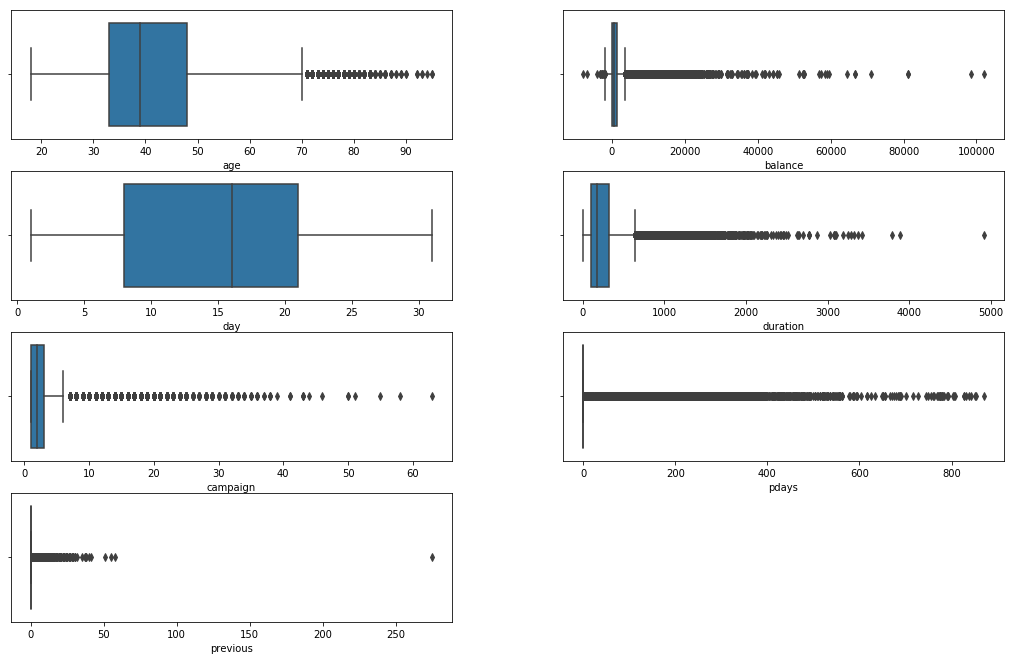

In [578]:
plt.figure(figsize=(15,10))
k=0
for i in range(1,len(Numerical)+1):
        plt.subplot(4,2,i)
        sns.boxplot(d[Numerical[i-1]],hue=d['Target'])
        plt.subplots_adjust(left=0.08, right=1, bottom=0.05, top=0.9,
                   hspace=0.25,wspace=0.25)

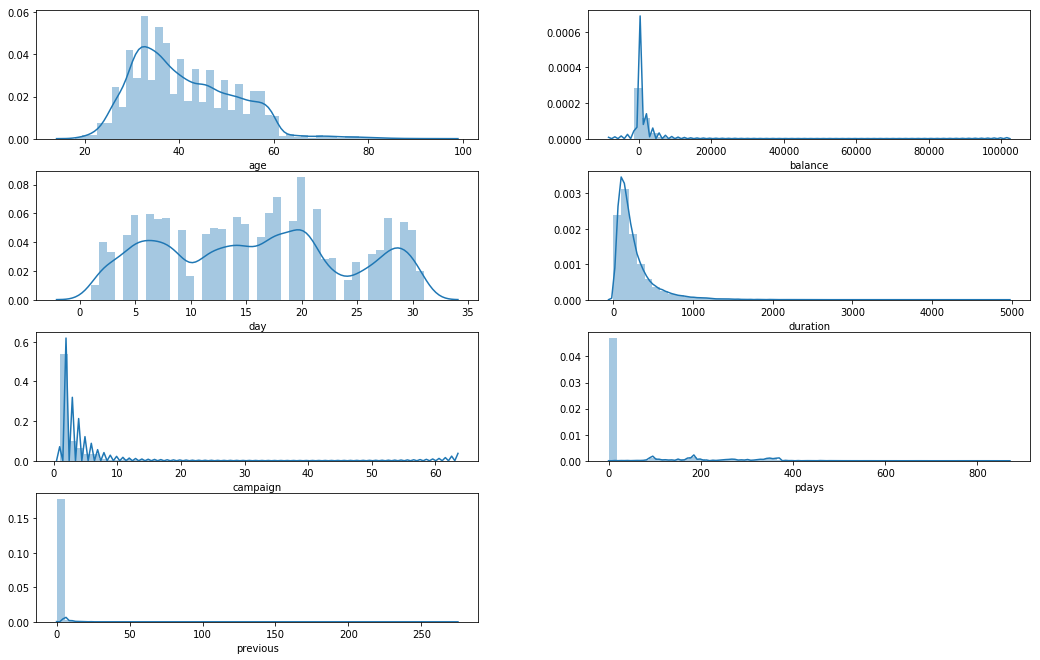

In [579]:
plt.figure(figsize=(15,10))
k=0
for i in range(1,len(Numerical)+1):
        plt.subplot(4,2,i)
        sns.distplot(d[Numerical[i-1]])
        plt.subplots_adjust(left=0.08, right=1, bottom=0.05, top=0.9,
                   hspace=0.25,wspace=0.25)  

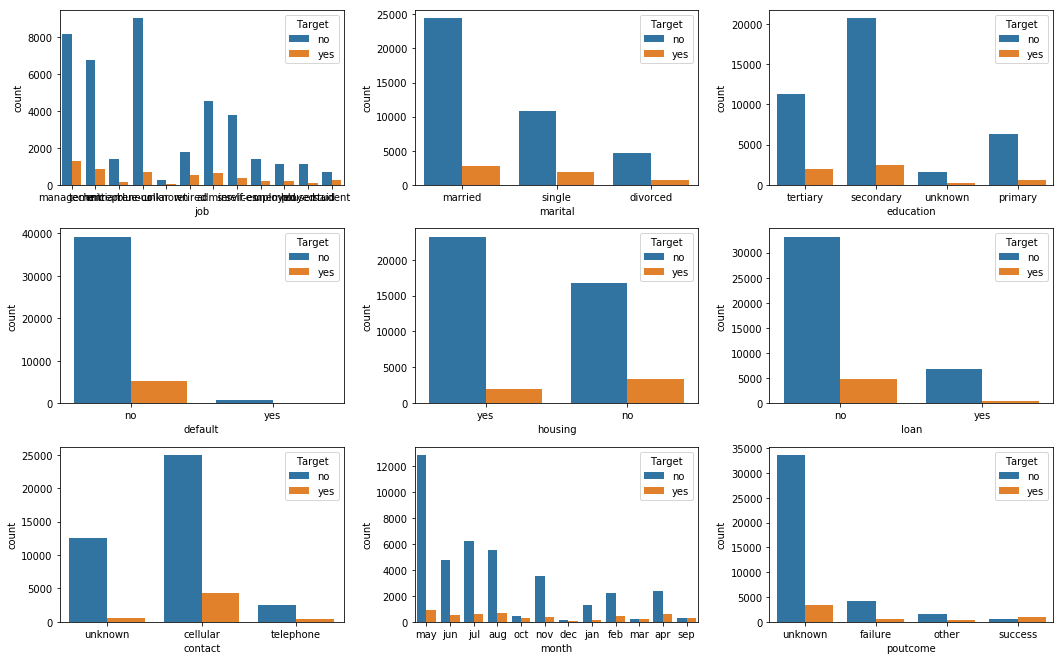

In [580]:
plt.figure(figsize=(15,10))
k=0
for i in range(1,len(Category)+1):
        plt.subplot(3,3,i)
        sns.countplot(d[Category[i-1]],hue=d['Target'])
        plt.subplots_adjust(left=0.08, right=1, bottom=0.05, top=0.9,
                   hspace=0.25,wspace=0.25)

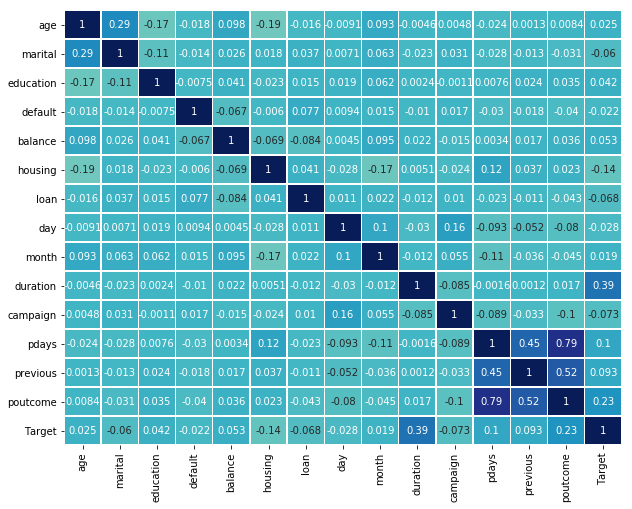

In [581]:
plt.figure(figsize=(10,8))
sns.heatmap(d1.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

Age: The median and mean looks close to each other. so probably a good distribution but, Outliers seems to exist in upper region look at boxplot

Martial : About 50 % of people seems to be in married status,Very few in divorced and some in single

Education : aproximtely about 50 % are in secondary education

Default : Largely people have NO and Very few have Yes. highly skewed. Might be a good idea to drop this column

Housing :From count plot the probability of pople subscribing the term deposit is high if the dont have housing loan seems reasonable. Good column to include in the model

loan :negative correlation with target, seems reasonable. Could try droping it


Balance:Mean and median are futher apart, Date is extremely rigth skewed with large number and value of outliers.Balance also has negative value. which seems logicla. Sometimes the balance becomes negative due to some penalty or something

Day: Its the day in a month. so seems no problem with outliers or missing values.Negative correlation with the data.  Shows high chance of getting a deposit if we contact the person at early of a month.

Duration : The duration of talk. From the data provider comments this high correlation with the output and should not be used in building the model. The correlation heatmap also shows the same

Campaign : Highly right skewed and have negative correlation with target. 

Pdays:Heavily skewed,Seems to have larger data with '-1' Value. Could be a missing value try droping this column

Previous: Heavily skewed,Seems to have larger data with '-1' Value. Could be a missing value try droping this column

Poutcome: Data is highly skewed with larger number of unknown values. But has positive correlation with the data. so a person who has bought already has a fair chance of getting a deposit again. Seems slightly less reasonable


# 3. See the distribution of 'Target' variable and plot it using appropriate graph

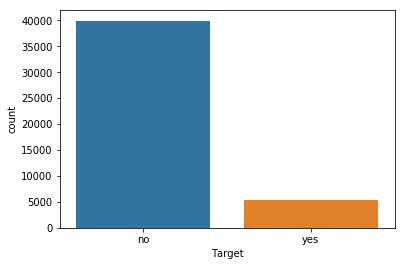

In [582]:
sns.countplot(d['Target'])

In [583]:
print("percent Accuracy the model will get if it guess all to be no ",1-sum(d1.Target)/d1['Target'].shape[0])

percent Accuracy the model will get if it guess all to be no  0.8830151954170445


So the model accuracy has to be higher than this and f1 score has to be considered in modelling

The distribution of the class is so large the difference between Yes and no data is almost 8 times

But lets concentrate on F1 score for the measure

# 4 Prepare the data to train a model – check if data types are appropriate, get rid of the missing values etc

In [584]:
for feature in d.columns: # Loop through all columns in the dataframe
    if d[feature].dtype == 'object': # Only apply for columns with categorical strings
        d[feature] = pd.Categorical(d[feature])# Replace strings with an integer
print(d.dtypes)
d.head(10)

age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
contact      category
day             int64
month        category
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome     category
Target       category
dtype: object


age           job   marital  education default  balance housing loan  \
0   58    management   married   tertiary      no     2143     yes   no   
1   44    technician    single  secondary      no       29     yes   no   
2   33  entrepreneur   married  secondary      no        2     yes  yes   
3   47   blue-collar   married    unknown      no     1506     yes   no   
4   33       unknown    single    unknown      no        1      no   no   
5   35    management   married   tertiary      no      231     yes   no   
6   28    management    single   tertiary      no      447     yes  yes   
7   42  entrepreneur  divorced   tertiary     yes        2     yes   no   
8   58       retired   married    primary      no      121     yes   no   
9   43    technician    single  secondary      no      593     yes   no   

   contact  day month  duration  campaign  pdays  previous poutcome Target  
0  unknown    5   may       261         1     -1         0  unknown     no  
1  unknown    5   may       151         1     -1         0  unknown     no  
2  unknown    5   may        76         1     -1         0  unknown     no  
3  unknown    5   may        92         1     -1         0  unknown     no  
4  unknown    5   may       198         1     -1         0  unknown     no  
5  unknown    5   may       139         1     -1         0  unknown     no  
6  unknown    5   may       217         1     -1         0  unknown     no  
7  unknown    5   may       380         1     -1         0  unknown     no  
8  unknown    5   may        50         1     -1         0  unknown     no  
9  unknown    5   may        55         1     -1         0  unknown     no

In [586]:
Stack=pd.DataFrame({})


In [591]:
F1=pd.DataFrame({})

In [587]:
d=d.replace({"Target":{"no":0,"yes":1}})

In [588]:
df=d.drop('duration',axis=1)
X_train,X_test,y_train,y_test=train_test_split(df.iloc[:,:-1],df.iloc[:,-1],test_size=0.3,random_state=2)
Numerical=['age','balance','day','campaign','pdays','previous']

In [589]:
print("The shape of training dataset{},shape of test dataset{},shape of whole dataset{}".format(X_train.shape,X_test.shape,d.shape))

The shape of training dataset(31647, 15),shape of test dataset(13564, 15),shape of whole dataset(45211, 17)


In [594]:
Numerical=['age','balance','day','campaign','previous','education','month']
Category=['job','marital','housing','poutcome','contact','default','loan']

replaceStruct = {"education":{"primary": 1, "secondary": 2 ,"tertiary": 3 ,"unknown":-1},
                 "default": {"no": 1, "yes":2},
                 "housing": {"no": 1, "yes":2},
                 "loan": {"no": 1, "yes":2},
                 "month": {"jan": 1, "feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12},     
                 "poutcome":{'unknown':-1,'failure':1,'other':1.5,'success':2},
                 "marital":{'married':2,'single':1,'divorced':3}}
d1=df.replace(replaceStruct)
X=pd.get_dummies(d1.iloc[:,:-1],columns=Category)
y=d1.iloc[:,-1]
X[Numerical]=(X[Numerical]-X[Numerical].mean())/X[Numerical].std()
#x=x.drop(['Online','Securities Account','CreditCard','CD Account'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

X_T=X_train
X_TT=X_test
y_t=y_train
y_tt=y_test


SVM = svm.SVC(gamma=0.025, C=3)
SVM.fit(X_T , y_t)
SVM_predict=SVM.predict(X_TT)
print("SVM confusion_matrix\n",confusion_matrix(y_tt,SVM_predict))
print("model_Accuracy:",SVM.score(X_TT,y_tt))
print("f1_score:",metrics.f1_score(y_tt,SVM_predict))
print("precisionScore:",metrics.precision_score(y_tt,SVM_predict))
print("Recall_score:",metrics.recall_score(y_tt,SVM_predict))

Logistic_model=LogisticRegression()
Logistic_model.fit(X_T,y_t)
Log_predict=Logistic_model.predict(X_TT)
print("Logistic Regression confusion_matrix\n",confusion_matrix(y_tt,Log_predict))
print("model_Accuracy:",Logistic_model.score(X_TT,y_tt))
print("f1_score:",metrics.f1_score(y_tt,Log_predict))
print("precisionScore:",metrics.precision_score(y_tt,Log_predict))
print("Recall_score:",metrics.recall_score(y_tt,Log_predict))

Naive_bayes=GaussianNB()
Naive_bayes.fit(X_T,y_t)
Naive_predict=Naive_bayes.predict(X_TT)
print("Naive_bayes confusion_matrix\n",confusion_matrix(y_tt,Naive_predict))
print("model_Accuracy:",Naive_bayes.score(X_TT,y_tt))
print("f1_score:",metrics.f1_score(y_tt,Naive_predict))
print("precisionScore:",metrics.precision_score(y_tt,Naive_predict))
print("Recall_score:",metrics.recall_score(y_tt,Naive_predict))

Knn=KNeighborsClassifier(n_neighbors=3,weights='distance')
Knn.fit(X_T,y_t)
Knn_predict=Knn.predict(X_TT)
print("Knearestneighbours confusion_matrix\n",confusion_matrix(y_tt,Knn_predict))
print("model_Accuracy:",Knn.score(X_TT,y_tt))
print("f1_score:",metrics.f1_score(y_tt,Knn_predict))
print("precisionScore:",metrics.precision_score(y_tt,Knn_predict))
print("Recall_score:",metrics.recall_score(y_tt,Knn_predict))

Stack['SVM']=SVM.predict(X_T)
Stack['log']=Logistic_model.predict(X_T)
Stack['Naive']=Naive_bayes.predict(X_T)
Stack['knn']=Knn.predict(X_T)

Stack1=pd.DataFrame({})
Stack1['SVM']=SVM.predict(X_TT)
Stack1['log']=Logistic_model.predict(X_TT)
Stack1['Naive']=Naive_bayes.predict(X_TT)
Stack1['knn']=Knn.predict(X_TT)



SVM confusion_matrix
 [[11910   103]
 [ 1311   240]]
model_Accuracy: 0.8957534650545562
f1_score: 0.2534318901795143
precisionScore: 0.6997084548104956
Recall_score: 0.15473887814313347


E:\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression confusion_matrix
 [[11878   135]
 [ 1281   270]]
model_Accuracy: 0.8956060159245061
f1_score: 0.27607361963190186
precisionScore: 0.6666666666666666
Recall_score: 0.17408123791102514
Naive_bayes confusion_matrix
 [[10009  2004]
 [  844   707]]
model_Accuracy: 0.7900324388086111
f1_score: 0.33176912247771
precisionScore: 0.26078937661379564
Recall_score: 0.4558349451966473
Knearestneighbours confusion_matrix
 [[11476   537]
 [ 1191   360]]
model_Accuracy: 0.8726039516366854
f1_score: 0.2941176470588235
precisionScore: 0.4013377926421405
Recall_score: 0.23210831721470018


Naive bayes even though it good in predicting ones. it has more false positive values. but it has high f1 score and precision and recall of 1.

Logistic Regression has more False negative values. It is more baised by values of 0

SVM seems to have good over all accuracy on comparison, but recall score is low meaning that the true negative values are more

Knn the model has moderate performance on comparison with above 3 models, but its true negative value is also more

In [595]:
F1['SVM']=metrics.f1_score(y_tt,SVM_predict)
F1['log']=metrics.f1_score(y_tt,Log_predict)
F1['Naive']=metrics.f1_score(y_tt,Naive_predict)
F1['knn']=metrics.f1_score(y_tt,Knn_predict)


In [596]:
Stack['Target']=np.array(y_train)
Log_model=LogisticRegression()
Log_model.fit(Stack.drop('Target',axis=1),Stack['Target'])
Log_predict=Log_model.predict(Stack1)
print("Logistic Regression confusion_matrix\n",confusion_matrix(y_tt,Log_predict))
print("model_Accuracy:",Log_model.score(Stack1,y_tt))
print("f1_score:",metrics.f1_score(y_tt,Log_predict))
print("precisionScore:",metrics.precision_score(y_tt,Log_predict))
print("Recall_score:",metrics.recall_score(y_tt,Log_predict))

Logistic Regression confusion_matrix
 [[11476   537]
 [ 1191   360]]
model_Accuracy: 0.8726039516366854
f1_score: 0.2941176470588235
precisionScore: 0.4013377926421405
Recall_score: 0.23210831721470018


E:\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The model tried is by stacking but ideals i should select a validation data set and train the stacked model in that by k fold stacking. But tried this to see how it works. the model provides same results as Knn

As pdays has negative values but Month and day have values which contradict the Pdays. so lets calculate the days from previous call using month and day and try dropping the pdays column. For handling outliers log values were taken but the reduced the result accuracy so not used

In [597]:
df=d.drop(['duration','pdays'],axis=1)

X_train,X_test,y_train,y_test=train_test_split(df.iloc[:,:-1],df.iloc[:,-1],test_size=0.3,random_state=1)
Numerical=['age','balance','day','campaign','previous','education','month']
Category=['job','marital','housing','poutcome','contact','default','loan']

replaceStruct = {"education":{"primary": 1, "secondary": 2 ,"tertiary": 3 ,"unknown":-1},
                 "default": {"no": 1, "yes":2},
                 "housing": {"no": 1, "yes":2},
                 "loan": {"no": 1, "yes":2},
                 "month": {"jan": 1, "feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12},     
                 "poutcome":{'unknown':-1,'failure':1,'other':1.5,'success':2},
                 "marital":{'married':2,'single':1,'divorced':3}}

d1=df.replace(replaceStruct)
#X1=np.log(d1[Numerical])
#X1=X1.replace({np.NaN:1,X1['previous'][0]:0})
#d1[Numerical]=X1
X=pd.get_dummies(d1.iloc[:,:-1],columns=Category)
y=d1.iloc[:,-1]
#X[Numerical]=np.log(X[Numerical])

X[Numerical]=(X[Numerical]-X[Numerical].mean())/X[Numerical].std()
#x=x.drop(['Online','Securities Account','CreditCard','CD Account'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

g=X_train[y_train==1]
g1=g

for i in range(4):
    g1=g1.append(g)
#for i in range(len(y_train)-sum(y_train)-g1.shape[0]):
 #   g1=g1.append(g.iloc[np.random.randint(0,sum(y_train))])
    
g2=np.ones(g1.shape[0])
g22=np.zeros(len(y_train)-sum(y_train))
x_zeros=X_train[y_train==0]

X_T=x_zeros.append(g1)
X_TT=X_test
y_t=np.append(g22,g2)
y_tt=y_test


Logistic_model=LogisticRegression()
Logistic_model.fit(X_T,y_t)
Log_predict=Logistic_model.predict(X_TT)
print("Logistic Regression confusion_matrix\n",confusion_matrix(y_tt,Log_predict))
print("model_Accuracy:",Logistic_model.score(X_TT,y_tt))
print("f1_score:",metrics.f1_score(y_tt,Log_predict))
print("precisionScore:",metrics.precision_score(y_tt,Log_predict))
print("Recall_score:",metrics.recall_score(y_tt,Log_predict))

Naive_bayes=GaussianNB()
Naive_bayes.fit(X_T,y_t)
Naive_predict=Naive_bayes.predict(X_TT)
print("Naive_bayes confusion_matrix\n",confusion_matrix(y_tt,Naive_predict))
print("model_Accuracy:",Naive_bayes.score(X_TT,y_tt))
print("f1_score:",metrics.f1_score(y_tt,Naive_predict))
print("precisionScore:",metrics.precision_score(y_tt,Naive_predict))
print("Recall_score:",metrics.recall_score(y_tt,Naive_predict))

Knn=KNeighborsClassifier(n_neighbors=3,weights='distance')
Knn.fit(X_T,y_t)
Knn_predict=Knn.predict(X_TT)
print("Knearestneighbours confusion_matrix\n",confusion_matrix(y_tt,Knn_predict))
print("model_Accuracy:",Knn.score(X_TT,y_tt))
print("f1_score:",metrics.f1_score(y_tt,Knn_predict))
print("precisionScore:",metrics.precision_score(y_tt,Knn_predict))
print("Recall_score:",metrics.recall_score(y_tt,Knn_predict))

SVM = svm.SVC(gamma=0.025, C=3)
SVM.fit(X_T , y_t)
SVM_predict=SVM.predict(X_TT)
print("SVM confusion_matrix\n",confusion_matrix(y_tt,SVM_predict))
print("model_Accuracy:",SVM.score(X_TT,y_tt))
print("f1_score:",metrics.f1_score(y_tt,SVM_predict))
print("precisionScore:",metrics.precision_score(y_tt,SVM_predict))
print("Recall_score:",metrics.recall_score(y_tt,SVM_predict))


E:\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression confusion_matrix
 [[10503  1510]
 [  821   730]]
model_Accuracy: 0.8281480389265703
f1_score: 0.38512265892904246
precisionScore: 0.32589285714285715
Recall_score: 0.4706640876853643
Naive_bayes confusion_matrix
 [[8868 3145]
 [ 627  924]]
model_Accuracy: 0.7219109407254497
f1_score: 0.3288256227758007
precisionScore: 0.22708282133202262
Recall_score: 0.5957446808510638
Knearestneighbours confusion_matrix
 [[10253  1760]
 [  911   640]]
model_Accuracy: 0.8030816868180478
f1_score: 0.32396861554036954
precisionScore: 0.26666666666666666
Recall_score: 0.4126370083816892
SVM confusion_matrix
 [[10794  1219]
 [  799   752]]
model_Accuracy: 0.8512238277794161
f1_score: 0.42703009653605906
precisionScore: 0.3815322171486555
Recall_score: 0.48484848484848486


Here the models with upsampling seems to provide better results of F1 score but the over all accuracy decreases. This shows that a balance has to be striked between them

In [598]:
Stack['SVMup']=SVM.predict(X_train)
Stack['logup']=Logistic_model.predict(X_train)
Stack['Naiveup']=Naive_bayes.predict(X_train)
Stack['knnup']=Knn.predict(X_train)
Stack1['SVMup']=SVM.predict(X_TT)
Stack1['logup']=Logistic_model.predict(X_TT)
Stack1['Naiveup']=Naive_bayes.predict(X_TT)
Stack1['knnup']=Knn.predict(X_TT)
F1['SVMupsampled']=metrics.f1_score(y_tt,SVM_predict)
F1['logupsampled']=metrics.f1_score(y_tt,Log_predict)
F1['Naiveupsampled']=metrics.f1_score(y_tt,Naive_predict)
F1['knnupsampled']=metrics.f1_score(y_tt,Knn_predict)

# 9. Create the decision tree model using “entropy” method of reducing the entropy and fit it to training data.

In [599]:
df=d.drop(['duration','pdays'],axis=1)

X_train,X_test,y_train,y_test=train_test_split(df.iloc[:,:-1],df.iloc[:,-1],test_size=0.3,random_state=1)
Numerical=['age','balance','day','campaign','previous']
Category=['job','marital','education','housing','loan','month','poutcome','default','contact']

replaceStruct = {"education":{"primary": 1, "secondary": 2 ,"tertiary": 3 ,"unknown":-1},
                 "default": {"no": 1, "yes":2},
                 "housing": {"no": 1, "yes":2},
                 "loan": {"no": 1, "yes":2},
                 "month": {"jan": 1, "feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12},     
                 "poutcome":{'unknown':-1,'failure':1,'other':2,'success':3},
                 "marital":{'married':2,'single':1,'divorced':3}}

d1=df.replace(replaceStruct)

X=pd.get_dummies(d1.iloc[:,:-1],columns=Category)
y=d1.iloc[:,-1]
X[Numerical]=(X[Numerical]-X[Numerical].mean())/X[Numerical].std()
#x=x.drop(['Online','Securities Account','CreditCard','CD Account'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)


In [600]:
Decision_model=DecisionTreeClassifier(criterion='entropy',random_state=1)
Decision_model.fit(X_train,y_train)
k1=Decision_model.predict(X_test)
print(confusion_matrix(y_test,k1))
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))
fea=pd.DataFrame({})
fea['columns']=X_train.columns
fea['feature']=Decision_model.feature_importances_
print(fea)
Stack1['Dtree']=k1
Stack['Dtree']=Decision_model.predict(X_train)
F1['Dtree']=metrics.f1_score(y_tt,k1)


[[10771  1242]
 [ 1036   515]]
accuracy: 0.8320554408728988
f1: 0.31136638452237003
precisionScore: 0.29311326124075127
Recall_score: 0.33204384268214054
              columns   feature
0                 age  0.142150
1             balance  0.234079
2                 day  0.112061
3            campaign  0.062446
4            previous  0.025093
5          job_admin.  0.011214
6     job_blue-collar  0.012886
7    job_entrepreneur  0.003896
8       job_housemaid  0.002414
9      job_management  0.013869
10        job_retired  0.003454
11  job_self-employed  0.006314
12       job_services  0.010192
13        job_student  0.004647
14     job_technician  0.014769
15     job_unemployed  0.005416
16        job_unknown  0.001225
17          marital_1  0.008863
18          marital_2  0.009483
19          marital_3  0.005946
20       education_-1  0.005324
21        education_1  0.010398
22        education_2  0.013408
23        education_3  0.014384
24          housing_1  0.007526
25          ho

Overfitting could be a problem lets try pruning by max_depth, The Pdays Value is dropped as it has more -1 value and contradicting with the month and days column,
The F1 score is 0.311 which is high compared to other base models without upsampling, but still not good enough, lets try pruning

In [601]:
Decision_model=DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=1)
Decision_model.fit(X_train,y_train)
k1=Decision_model.predict(X_test)
print(confusion_matrix(y_test,k1))
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))
Stack1['Dtree_prune']=k1
Stack['Dtree_prune']=Decision_model.predict(X_train)
F1['Dtree_prune']=metrics.f1_score(y_tt,k1)

[[11793   220]
 [ 1233   318]]
accuracy: 0.8928782070185786
f1: 0.3044518908568693
precisionScore: 0.5910780669144982
Recall_score: 0.20502901353965183


The max depth of 10 is chosen as it seems to provide better results with decision tree with class weights
Even though the f1 score reduced the accuracy went up.. lets compensate for this f1 score reduction with providing class weight

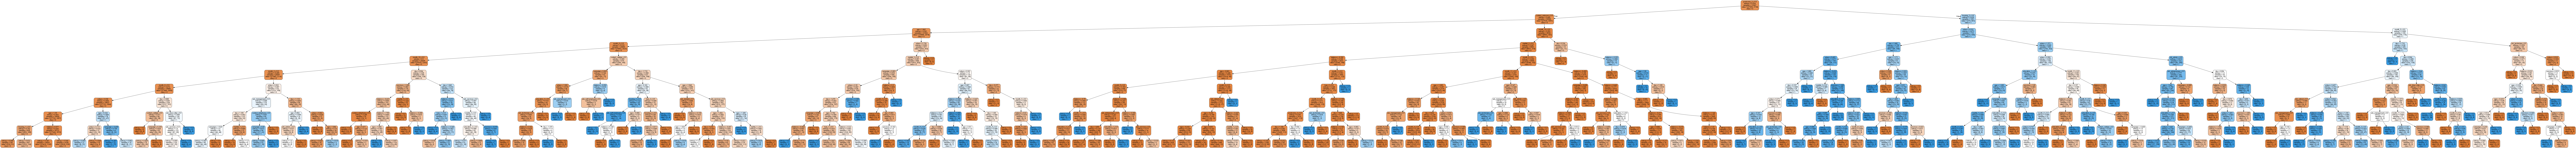

In [269]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz

xvar = X_train
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(Decision_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('deposit.png')
Image(graph.create_png())

In [602]:
Decision_model=DecisionTreeClassifier(criterion='gini',max_depth=10,random_state=1)
Decision_model.fit(X_train,y_train)
k1=Decision_model.predict(X_test)
print(confusion_matrix(y_test,k1))
print(confusion_matrix(y_test,k1))
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))

[[11749   264]
 [ 1205   346]]
[[11749   264]
 [ 1205   346]]
accuracy: 0.8916986139781775
f1: 0.3202221193891716
precisionScore: 0.5672131147540984
Recall_score: 0.22308188265635073


In [603]:
Decision_model=DecisionTreeClassifier(class_weight={0:1,1:5},criterion='entropy',max_depth=10,random_state=1)
Decision_model.fit(X_train,y_train)
k1=Decision_model.predict(X_test)
print(confusion_matrix(y_test,k1))
print(confusion_matrix(y_test,k1))
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))

[[10798  1215]
 [  763   788]]
[[10798  1215]
 [  763   788]]
accuracy: 0.8541728103804187
f1: 0.44344400675295437
precisionScore: 0.3934098851722416
Recall_score: 0.5080593165699548


In [604]:
Decision_model=DecisionTreeClassifier(class_weight={0:1,1:5},criterion='gini',max_depth=10,random_state=1)
Decision_model.fit(X_train,y_train)
k1=Decision_model.predict(X_test)
print(confusion_matrix(y_test,k1))
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))
fea=pd.DataFrame({})
fea['columns']=X_train.columns
fea['feature']=Decision_model.feature_importances_
print(fea)
Stack1['Dtree_classweight']=k1
Stack['Dtree_classweight']=Decision_model.predict(X_train)
F1['Dtree_classweight']=metrics.f1_score(y_tt,k1)

[[10801  1212]
 [  752   799]]
accuracy: 0.8552049542907697
f1: 0.44862436833239755
precisionScore: 0.39731476877175537
Recall_score: 0.5151515151515151
              columns   feature
0                 age  0.040865
1             balance  0.058035
2                 day  0.100663
3            campaign  0.028083
4            previous  0.027918
5          job_admin.  0.001679
6     job_blue-collar  0.001745
7    job_entrepreneur  0.001646
8       job_housemaid  0.000954
9      job_management  0.001946
10        job_retired  0.002261
11  job_self-employed  0.000425
12       job_services  0.002093
13        job_student  0.000226
14     job_technician  0.002111
15     job_unemployed  0.000415
16        job_unknown  0.001064
17          marital_1  0.007911
18          marital_2  0.012586
19          marital_3  0.000381
20       education_-1  0.000000
21        education_1  0.004380
22        education_2  0.000000
23        education_3  0.005984
24          housing_1  0.056938
25          hou

It seems Gini impurity criterain with class weight of 1:5 and max depth 10 gives ok f1score. based on trials(not shown here)

# 11. Apply the Random forest model and print the accuracy of Random forest Model

In [605]:
Random_model=RandomForestClassifier(criterion='gini',random_state=1)
Random_model.fit(X_train,y_train)
print(confusion_matrix(y_test,Random_model.predict(X_test)))
k1=Random_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))

E:\python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[11735   278]
 [ 1211   340]]
accuracy: 0.8902241226776763
f1: 0.3135085292761641
precisionScore: 0.5501618122977346
Recall_score: 0.2192134107027724


In [606]:
Random_model=RandomForestClassifier(n_estimators=100,criterion='gini',random_state=1)
Random_model.fit(X_train,y_train)
print(confusion_matrix(y_test,Random_model.predict(X_test)))
k1=Random_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))
Stack1['RF']=k1
Stack['RF']=Random_model.predict(X_train)
F1['Random_forest']=metrics.f1_score(y_tt,k1)

[[11740   273]
 [ 1162   389]]
accuracy: 0.8942052491890298
f1: 0.3515589697243561
precisionScore: 0.5876132930513596
Recall_score: 0.2508059316569955


In [607]:
Random_model=RandomForestClassifier(n_estimators=100,criterion='gini',random_state=1,class_weight={0:1,1:5})
Random_model.fit(X_train,y_train)
print(confusion_matrix(y_test,Random_model.predict(X_test)))
k1=Random_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))

[[11782   231]
 [ 1203   348]]
accuracy: 0.8942789737540549
f1: 0.3267605633802817
precisionScore: 0.6010362694300518
Recall_score: 0.22437137330754353


In [426]:
Random_model=RandomForestClassifier(n_estimators=100,criterion='gini',random_state=1,class_weight={0:1,1:5},max_depth=5)
Random_model.fit(X_train,y_train)
print(confusion_matrix(y_test,Random_model.predict(X_test)))
k1=Random_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))

[[11176   837]
 [  908   643]]
accuracy: 0.8713506340312592
f1: 0.4242824150445398
precisionScore: 0.43445945945945946
Recall_score: 0.4145712443584784


In [427]:
Random_model=RandomForestClassifier(n_estimators=150,criterion='gini',random_state=1,class_weight={0:1,1:5},max_depth=5)
Random_model.fit(X_train,y_train)
print(confusion_matrix(y_test,Random_model.predict(X_test)))
k1=Random_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))
fea=pd.DataFrame({})
fea['columns']=X_train.columns
fea['feature']=Random_model.feature_importances_
print(fea)

[[11172   841]
 [  907   644]]
accuracy: 0.871129460336184
f1: 0.4242424242424242
precisionScore: 0.43367003367003365
Recall_score: 0.4152159896840748
              columns   feature
0                 age  0.065378
1             balance  0.041614
2                 day  0.011733
3            campaign  0.013402
4            previous  0.056857
5          job_admin.  0.000585
6     job_blue-collar  0.007023
7    job_entrepreneur  0.000218
8       job_housemaid  0.000440
9      job_management  0.000501
10        job_retired  0.003734
11  job_self-employed  0.000183
12       job_services  0.000214
13        job_student  0.004386
14     job_technician  0.000515
15     job_unemployed  0.000164
16        job_unknown  0.000124
17          marital_1  0.005859
18          marital_2  0.007489
19          marital_3  0.000634
20       education_-1  0.000204
21        education_1  0.001445
22        education_2  0.000486
23        education_3  0.002100
24          housing_1  0.060969
25          housi

In [438]:
for i in range(1,15):
    Random_model=RandomForestClassifier(n_estimators=150,criterion='gini',random_state=1,class_weight={0:1,1:5},max_depth=i)
    Random_model.fit(X_train,y_train)
    print(confusion_matrix(y_test,Random_model.predict(X_test)))
    k1=Random_model.predict(X_test)
    print(i)
    print("accuracy:",metrics.accuracy_score(y_test,k1))
    print("f1:",metrics.f1_score(y_test,k1))
    print("precisionScore:",metrics.precision_score(y_tt,k1))
    print("Recall_score:",metrics.recall_score(y_tt,k1))

[[11868   145]
 [ 1268   283]]
1
accuracy: 0.8958271896195813
f1: 0.28600303183425974
precisionScore: 0.6612149532710281
Recall_score: 0.1824629271437782
[[11523   490]
 [ 1114   437]]
2
accuracy: 0.8817457976997936
f1: 0.35270379338175956
precisionScore: 0.4714131607335491
Recall_score: 0.28175370728562216
[[11312   701]
 [ 1027   524]]
3
accuracy: 0.8726039516366854
f1: 0.377521613832853
precisionScore: 0.42775510204081635
Recall_score: 0.33784655061250807
[[11248   765]
 [  973   578]]
4
accuracy: 0.8718667059864347
f1: 0.39944713199723564
precisionScore: 0.43037974683544306
Recall_score: 0.3726627981947131
[[11172   841]
 [  907   644]]
5
accuracy: 0.871129460336184
f1: 0.4242424242424242
precisionScore: 0.43367003367003365
Recall_score: 0.4152159896840748
[[11114   899]
 [  868   683]]
6
accuracy: 0.8697286936007077
f1: 0.43600383019470157
precisionScore: 0.43173198482932995
Recall_score: 0.440361057382334
[[11036   977]
 [  823   728]]
7
accuracy: 0.8672957829548805
f1: 0.4471744

In [432]:
for i in range(1,10):
    Random_model=RandomForestClassifier(n_estimators=100,criterion='gini',random_state=1,class_weight={0:1,1:5},max_depth=5,max_features=i)
    Random_model.fit(X_train,y_train)
    print(i)
    print(confusion_matrix(y_test,Random_model.predict(X_test)))
    k1=Random_model.predict(X_test)
    print("accuracy:",metrics.accuracy_score(y_test,k1))
    print("f1:",metrics.f1_score(y_test,k1))
    print("precisionScore:",metrics.precision_score(y_tt,k1))
    print("Recall_score:",metrics.recall_score(y_tt,k1)) 


1
[[11713   300]
 [ 1201   350]]
accuracy: 0.8893394278973754
f1: 0.31803725579282144
precisionScore: 0.5384615384615384
Recall_score: 0.2256608639587363
2
[[11413   600]
 [ 1042   509]]
accuracy: 0.8789442642288411
f1: 0.3827067669172932
precisionScore: 0.45897204688908927
Recall_score: 0.32817537072856223
3
[[11299   714]
 [  982   569]]
accuracy: 0.8749631377174875
f1: 0.4015525758645025
precisionScore: 0.4434918160561185
Recall_score: 0.3668600902643456
4
[[11236   777]
 [  949   602]]
accuracy: 0.8727514007667355
f1: 0.41092150170648467
precisionScore: 0.4365482233502538
Recall_score: 0.38813668600902645
5
[[11197   816]
 [  936   615]]
accuracy: 0.8708345620760838
f1: 0.41247484909456744
precisionScore: 0.429769392033543
Recall_score: 0.3965183752417795
6
[[11203   810]
 [  937   614]]
accuracy: 0.8712031849012091
f1: 0.4127731092436975
precisionScore: 0.4311797752808989
Recall_score: 0.39587362991618313
7
[[11176   837]
 [  908   643]]
accuracy: 0.8713506340312592
f1: 0.42428241

In [608]:
Random_model=RandomForestClassifier(n_estimators=150,criterion='gini',random_state=1,class_weight={0:1,1:5},max_depth=12)
Random_model.fit(X_train,y_train)
print(confusion_matrix(y_test,Random_model.predict(X_test)))
k1=Random_model.predict(X_test)
print(i)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))
Stack1['RF1']=k1
Stack['RF1']=Random_model.predict(X_train)
F1['Random_forest_weighted']=metrics.f1_score(y_tt,k1)

[[11122   891]
 [  828   723]]
3
accuracy: 0.873267472721911
f1: 0.45687203791469194
precisionScore: 0.4479553903345725
Recall_score: 0.4661508704061896


with these parameters " n_estimators=150,criterion='gini',random_state=1,class_weight={0:1,1:5},max_depth=12 " the Random forest model seems to equal precision and recall..

but their values are near 0.5 it is like tossing a coin

# 12. Apply Adaboost Ensemble Algorithm for the same data and print the accuracy.

In [497]:
Ada_model=AdaBoostClassifier(random_state=3)
Ada_model.fit(X_train,y_train)
print(confusion_matrix(y_test,Ada_model.predict(X_test)))
k1=Ada_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))


[[11845   168]
 [ 1253   298]]
accuracy: 0.8952373930993807
f1: 0.29548834903321763
precisionScore: 0.6394849785407726
Recall_score: 0.19213410702772404


In [609]:
Ada_model=AdaBoostClassifier(base_estimator=Random_model,random_state=3)
Ada_model.fit(X_train,y_train)
print(confusion_matrix(y_test,Ada_model.predict(X_test)))
k1=Ada_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))
Stack1['ada']=k1
Stack['ada']=Ada_model.predict(X_train)
F1['Adaboosting']=metrics.f1_score(y_tt,k1)

[[11621   392]
 [ 1131   420]]
accuracy: 0.887717487466824
f1: 0.3554803216250529
precisionScore: 0.5172413793103449
Recall_score: 0.27079303675048355


# 13. Apply Bagging Classifier Algorithm and print the accuracy.

In [610]:
Bagg_model=BaggingClassifier(random_state=3,max_features=0.8)
Bagg_model.fit(X_train,y_train)
print(confusion_matrix(y_test,Bagg_model.predict(X_test)))
k1=Bagg_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))
F1['Bagging']=metrics.f1_score(y_tt,k1)

[[11729   284]
 [ 1181   370]]
accuracy: 0.8919935122382778
f1: 0.3356009070294785
precisionScore: 0.5657492354740061
Recall_score: 0.2385557704706641


In [453]:
Bagg_model=BaggingClassifier(base_estimator=Random_model,random_state=3,max_features=0.8)
Bagg_model.fit(X_train,y_train)
print(confusion_matrix(y_test,Bagg_model.predict(X_test)))
k1=Bagg_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))


[[11828   185]
 [ 1226   325]]
accuracy: 0.8959746387496313
f1: 0.3153808830664726
precisionScore: 0.6372549019607843
Recall_score: 0.20954223081882656


# 14. Apply GradientBoost Classifier Algorithm for the same data and print the accuracy

In [611]:
gradient_model=GradientBoostingClassifier(random_state=3)
gradient_model.fit(X_train,y_train)
print(confusion_matrix(y_test,gradient_model.predict(X_test)))
k1=gradient_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))
F1['Gradient_boosting']=metrics.f1_score(y_tt,k1)

[[11817   196]
 [ 1233   318]]
accuracy: 0.8946475965791801
f1: 0.3079903147699758
precisionScore: 0.6186770428015564
Recall_score: 0.20502901353965183


Lets try different Gradient bossting with lightGBM and XB boost

# Light GBM

In [459]:
lgb_train=lgb.Dataset(X_train,y_train)
params={'task':'train','boosting_type':'gbdt','objective':'multiclass','num_class':2,'metric':'multi_logloss'}
lgb_model=lgb.train(params,lgb_train)
prediction=lgb_model.predict(X_test)
predict=[]
for i in prediction:
    predict.append(np.argmax(i))
k1=predict
print(confusion_matrix(y_test,k1))
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_tt,k1))
print("Recall_score:",metrics.recall_score(y_tt,k1))

[[11745   268]
 [ 1167   384]]
accuracy: 0.8942052491890298
f1: 0.3486155242850658
precisionScore: 0.588957055214724
Recall_score: 0.24758220502901354


0.8964907107048068
[[11736   277]
 [ 1127   424]]


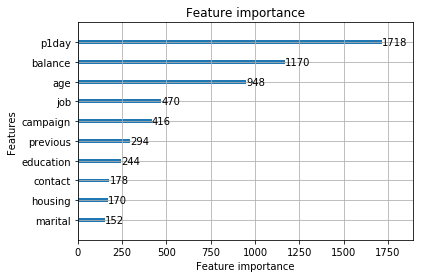

In [613]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from scipy.stats import zscore
replaceStruct = {
                "education":{"primary": 1, "secondary": 2 ,"tertiary": 3 ,"unknown":-1},
                "default": {"no": 1, "yes":2},
                "housing": {"no": 1, "yes":2},
                "loan": {"no": 1, "yes":2},
                "month": {"jan": 1, "feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12},     
                "phone": {"no": 1, "yes": 2 },
                "poutcome":{'unknown':-1,'failure':1,'other':2,'success':3},
                "marital":{'married':2,'single':1,'divorced':1}}
newd=d.replace(replaceStruct)

y = newd.Target
X = newd.drop(['Target','duration','pdays'], axis=1)
X1=X
p1day=(12-X1['month'])*30+31-X1['day']
X1['p1day']=p1day
X1=X1.drop(['month','day'], axis=1)

features=[]
for i in range(0,X1.columns.shape[0]):    
    if i != X1.columns.shape[0]: #skip target
        features.append(X1.columns[i])
category=['job','marital','contact','poutcome','default','housing','loan','poutcome','marital']
#category=['job','marital','contact','poutcome']
labelcode=['job','contact']

for i in labelcode:
        le.fit(X1[i])
        encoded_feature = le.transform(X1[i])
        X1[i] = pd.DataFrame(encoded_feature)

#X1[['balance','age','p1day']]=X1[['balance','age','p1day']].apply(zscore)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=1)
lgb_train = lgb.Dataset(X_train, y_train)
params = {
      'task': 'train'
    , 'boosting_type': 'gbdt'
    , 'objective':'multiclass'
    , 'num_class': 2
    , 'metric':'multi_logloss'
    , 'min_data': 1
    ,'learning_rate':0.1
    , 'verbose': -1    
}

gbm1= lgb.train(params, lgb_train, num_boost_round=100,)
prediction=gbm1.predict(X_test)
predict=[]
for i in prediction:
    predict.append(np.argmax(i))
print(metrics.accuracy_score(predict,y_test))
print(confusion_matrix(y_test,predict))
ax = lgb.plot_importance(gbm1, max_num_features=10)
plt.show()




In [616]:
print("f1:",metrics.f1_score(y_test,predict))

f1: 0.3765541740674956


In [617]:
prediction=gbm1.predict(X_train)
predictt=[]
for i in prediction:
    predictt.append(np.argmax(i))
Stack1['lgbm']=predict
Stack['lgbm']=predictt
F1['lightgbm']=metrics.f1_score(y_tt,predict)

# XGboost

In [618]:
xg_train=xgb.DMatrix(X_train,label=y_train)
xg_test=xgb.DMatrix(X_test,label=y_test)
params1={'eta':0.3,'objective':'multi:softprob','num_class':2}
xgb_model=xgb.train(params1,xg_train)
predictions=xgb_model.predict(xg_test)

E:\python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [619]:
predicts=[]
for i in predictions:
    predicts.append(np.argmax(i))


In [620]:
print(metrics.accuracy_score(predicts,y_test))
print(confusion_matrix(y_test,predicts))

0.8959746387496313
[[11856   157]
 [ 1254   297]]


In [621]:
x_model=xgb.XGBClassifier(subsample=0.8,colsample_bytree=0.8,scale_pos_weight=5)
xgb_model=x_model.fit(X_train,y_train)
predicts1=xgb_model.predict(X_test)
k1=predicts1
print(confusion_matrix(y_test,k1))
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_test,k1))
print("Recall_score:",metrics.recall_score(y_test,k1))
Stack1['xgb']=k1
Stack['xgb']=xgb_model.predict(X_train)
F1['XGboost_weighted']=metrics.f1_score(y_tt,k1)

[[10856  1157]
 [  679   872]]
accuracy: 0.8646416986139782
f1: 0.4871508379888268
precisionScore: 0.4297683587974372
Recall_score: 0.5622179239200515


# Catboost

In [622]:
cat_model = CatBoostClassifier(iterations=300,verbose=0,random_seed=43)
cat_model.fit(X_train, y_train)
print(metrics.accuracy_score(cat_model.predict(X_test),y_test))
print(confusion_matrix(y_test,cat_model.predict(X_test)))
print(metrics.f1_score(y_test,cat_model.predict(X_test)))


0.8953848422294308
[[11744   269]
 [ 1150   401]]
0.3610986042323278


In [623]:
df=d.drop(['duration'],axis=1)
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [624]:
X_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome'],
      dtype='object')

In [625]:
category_in=[1, 2, 3, 4, 6, 7, 8, 10, 14]
cat_model = CatBoostClassifier(iterations=300,verbose=0,random_seed=43)
cat_model.fit(X_train, y_train,cat_features=category_in)
print(metrics.accuracy_score(cat_model.predict(X_test),y_test))
print(confusion_matrix(y_test,cat_model.predict(X_test)))
print(metrics.f1_score(y_test,cat_model.predict(X_test)))
cat_model.get_feature_importance(prettified=True)

0.8962695370097317
[[11741   272]
 [ 1135   416]]
0.3715944618133095


Feature Id  Importances
0       month    18.739260
1         day    11.984196
2     contact    10.869407
3         age     9.603536
4     balance     9.099545
5    poutcome     7.394931
6       pdays     6.848834
7     housing     5.764779
8         job     4.858255
9    campaign     4.405265
10    marital     3.745083
11  education     3.033043
12   previous     2.187574
13       loan     1.336106
14    default     0.130186

In [626]:
category_in=[1, 2, 3, 4, 6, 7, 8, 10, 14]
cat_model = CatBoostClassifier(iterations=300,verbose=0,random_seed=1,class_weights=[1,4])
cat_model.fit(X_train, y_train,cat_features=category_in)
print(metrics.accuracy_score(cat_model.predict(X_test),y_test))
print(confusion_matrix(y_test,cat_model.predict(X_test)))
print(metrics.f1_score(y_test,cat_model.predict(X_test)))
cat_model.get_feature_importance(prettified=True)
k1=cat_model.predict(X_test)
print("accuracy:",metrics.accuracy_score(y_test,k1))
print("f1:",metrics.f1_score(y_test,k1))
print("precisionScore:",metrics.precision_score(y_test,k1))
print("Recall_score:",metrics.recall_score(y_test,k1))
Stack1['cat']=cat_model.predict(X_test)
Stack['cat']=cat_model.predict(X_train)
F1['Cat_boost_weighted']=metrics.f1_score(y_tt,k1)

0.8742996166322619
[[11041   972]
 [  733   818]]
0.48967375037413946
accuracy: 0.8742996166322619
f1: 0.48967375037413946
precisionScore: 0.4569832402234637
Recall_score: 0.5274016763378465


# Stacking of all the Previous Results

In [627]:
d1=pd.DataFrame({})
kk=np.sum(Stack1,axis=1)
mm=pd.DataFrame({})
a=[]
p=[]
f1=[]
R=[]
for i in range(1,13):
    d22=[]
    d22.append([1 if kk[x]>=i else 0 for x in range(0,Stack1.shape[0])])
    a.append(metrics.accuracy_score(y_test,np.array(d22).reshape(-1)))
    f1.append(metrics.f1_score(y_test,np.array(d22).reshape(-1)))
    p.append(metrics.precision_score(y_test,np.array(d22).reshape(-1)))
    R.append(metrics.recall_score(y_test,np.array(d22).reshape(-1)))
    
mm['accuracy']=a
mm['f1_score']=f1
mm['precision']=p
mm['Recall']=R

Text(0.5, 0, 'threshold')

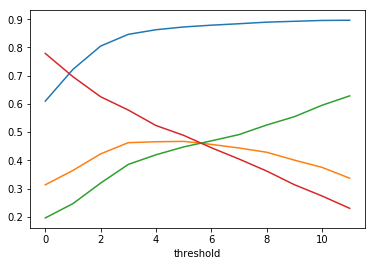

In [628]:
plt.plot(mm)
plt.xlabel('threshold')

From Graph it is known that the model gives optimal results in terms of both precision and accuracy for a threshold value of between 5 and 6

In [638]:
print(mm.iloc[5,:])
print(mm.iloc[6,:])
print(mm.iloc[6,:]*0.6+mm.iloc[5,:]*0.4)


accuracy     0.872604
f1_score     0.467324
precision    0.447726
Recall       0.488717
Name: 5, dtype: float64
accuracy     0.878944
f1_score     0.456651
precision    0.469069
Recall       0.444874
Name: 6, dtype: float64
accuracy     0.876408
f1_score     0.460920
precision    0.460532
Recall       0.462411
dtype: float64


In [652]:
F1_score=[]
for feature in Stack1.columns:
    F1_score.append(metrics.f1_score(y_test,Stack1[feature]))

In [664]:
F1score=pd.DataFrame({})
F1score['model']=Stack1.columns
F1score['F1_score']=F1_score


# Conclusion

Top models with best F1 score are Catboost,XGboost and Random Forest as shown Below

In [668]:
F1score

model  F1_score
0                 SVM  0.253432
1                 log  0.276074
2               Naive  0.331769
3                 knn  0.294118
4               SVMup  0.427030
5               logup  0.385123
6             Naiveup  0.328826
7               knnup  0.323969
8               Dtree  0.311366
9         Dtree_prune  0.304452
10  Dtree_classweight  0.448624
11                 RF  0.351559
12                RF1  0.456872
13                ada  0.355480
14               lgbm  0.376554
15                xgb  0.487151
16                cat  0.489674